In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
import scipy
import cv2
from scipy import ndimage
import Image_preperation as prep
import FitFunction as fit
import FileManager as fm
import Image_preperation as prep
    
def calc_mean(points):
    
    size = len(points)
    p1 = points[-1]
    p2 = points[0]
    mean_sum = scipy.spatial.distance.euclidean(p1,p2)
    
    for i in range(size-1):
        p1 = points[i]
        p2 = points[i+1]
        mean_sum += scipy.spatial.distance.euclidean(p1,p2)
        
    return mean_sum / size


def calc_internal2(p1,p2,mean_points):
    return np.sum( (p2 - p1)**2 ) / mean_points

def calc_internal(p1,p2,mean_points):
    return scipy.spatial.distance.euclidean(p1,p2) / mean_points

def calc_external_img2(img):
    median = prep.median_filter(img)
    edges = prep.edge_detection_low(median)
    return -edges

def calc_external_img(img): 

    img = np.array(img, dtype=np.int16)
    kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gx = cv2.filter2D(img,-1,kx)
    
    ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    Gy = cv2.filter2D(img,-1,ky)
    
    G = np.sqrt(Gx**2 + Gy**2)
    
    return G
    
def calc_external(p, external_img):
    
    p = p.astype(int)
    max_value = np.abs(np.min(external_img))
    
    return external_img[p[1],p[0]] / max_value
    
def calc_energy(p1, p2, external_img, mean_points,alpha):
     
    internal = calc_internal(p1,p2, mean_points)
    external = calc_external(p1, external_img)
    
    return internal + alpha * external


def get_point_state(point, rad, number, pixel_width):
    
    positive = number // 2
    if(positive == 1):
        state = (number + 1) / 2
    else:
        state = -(number / 2)
        
    return fit.get_point_at_distance(point, state, rad)

def unpack(number, back_pointers, angles, points, pixel_width):
    
    size = len(points)
    new_points = np.empty((size,2))
    
    new_points[-1] = get_point_state(points[-1],angles[-1], number, pixel_width)
    pointer = back_pointers[-1,number]
    
    for i in range(size-2, -1, -1):
        
        new_points[i] = get_point_state(points[i],angles[i], pointer, pixel_width)
        pointer = back_pointers[i,pointer]
        
    return new_points

#https://courses.engr.illinois.edu/cs447/fa2017/Slides/Lecture07.pdf
#viterbi algo
def active_contour(points, edge_img, pixel_width, alpha):
    size = len(points)
    num_states = (2*pixel_width +1)
    
    trellis = np.zeros((size, num_states), dtype=np.float16)
    back_pointers = np.zeros((size, num_states), dtype=int)
    #external_img = calc_external_img(img)
    if(np.dtype('bool') == edge_img.dtype):
        external_img = -np.array(edge_img,dtype=np.int8)
    else:
        external_img = -edge_img 
    mean_points = calc_mean(points)
    
    #init
    trellis[0,:] = np.zeros((num_states))
    back_pointers[0,:] = np.zeros((num_states))
    
    angles = get_angles_of(points)
    
    #recursion
    for i in range(1, size):
        for t in range(num_states):
            trellis[i,t] = np.inf
            for d in range(num_states):
                p1 = get_point_state(points[i-1], angles[i-1], d, pixel_width)
                p2 = get_point_state(points[i],angles[i], t, pixel_width)
                energy_trans = calc_energy(p1, p2, external_img,mean_points, alpha)

                tmp = trellis[i-1,d] + energy_trans

                if(tmp < trellis[i,t]):
                    trellis[i,t] = tmp
                    back_pointers[i,t] = d
            
    #find best
    t_best, vit_min = 0, np.inf
    for t in range(num_states):
        if(trellis[size-1, t] < vit_min):
            t_best = t
            vit_min = trellis[size-1, t]

    new_points = unpack(t_best, back_pointers,angles, points, pixel_width)
    return new_points


def active_contour_loop(points, img, max_loop, pixel_width, alpha):
    
    old_points = points
    for i in range(max_loop):
        new_points = active_contour(old_points, img, pixel_width, alpha)
        if np.array_equal(new_points, old_points):
            print(i)
            break
            
        #old_points = new_points
        head, tail = np.split(new_points, [6])
        old_points = np.append(tail, head).reshape(new_points.shape)
        
    return new_points

def resolution_scale(img, points, scale):
    new_points = resolution_scale_points(points, scale)
    new_img = resolution_downscale_img(img, scale)
    return new_img, new_points

def resolution_scale_points(points, scale): 
    return np.around(points*scale)

def resolution_downscale_img(img, scale): 
    x, y = img.shape
    xn = int(x*scale)
    yn = int(y*scale)

    return cv2.resize(img, (yn ,xn)) 

def get_angles_of(points):
    
    size = len(points)
    angles = np.zeros(size)
    
    for i in range(size):
        
        if(i==size-1):
            p1, p2, p3 = points[i-1], points[i], points[0] 
        else:
            p1, p2, p3 = points[i-1], points[i], points[i+1]

        angles[i] = fit.get_normal_angle(p1, p2, p3)
        
    return angles                                    
        
    

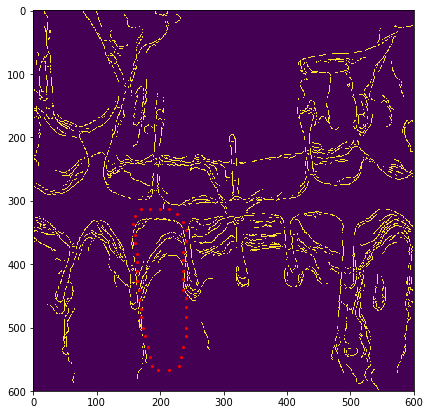

TypeError: src data type = 0 is not supported

In [2]:
if __name__ == "__main__":

    piece = fm.load_img_piece()
    tooth = fm.load_tooth_of_piece()
    ext = prep.calc_external_img_active_contour(piece) 
    fm.show_with_points(ext, tooth)
    ext2, stooth = fm.resolution_scale(ext, tooth, 1/6)
    fm.show_with_points(ext2, stooth)

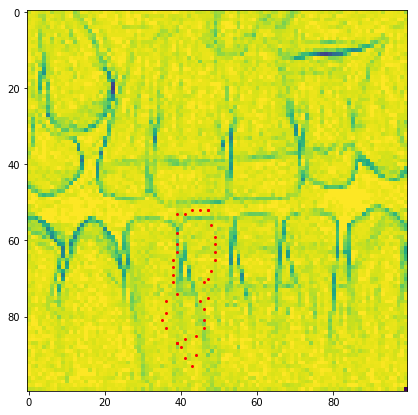

In [36]:
    new_tooth = active_contour(stooth, ext2, 10, 5)
    fm.show_with_points(ext2, new_tooth)

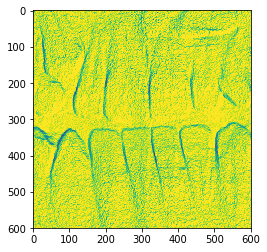

In [4]:
    ext = calc_external_img(piece)
    fm.show(ext)

In [ ]:
    new_tooth = active_contour(tooth, piece, 20, 10)
    fm.show_with_points(ext, new_tooth)

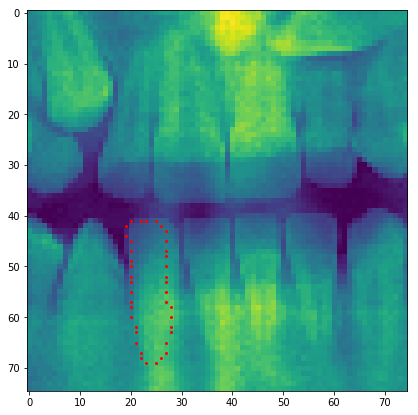

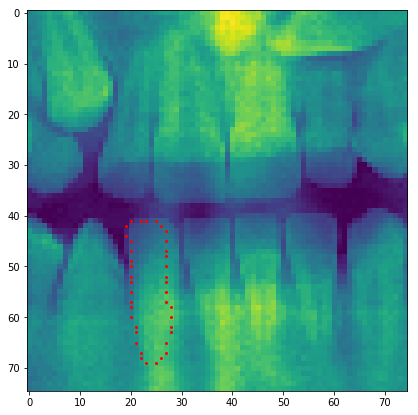

In [3]:
    new_img, new_points = resolution_scale(piece, tooth, 1/8)
    fm.show_with_points(new_img, new_points)
    new_tooth = active_contour_loop(new_points, new_img, 1, 10, 10)
    fm.show_with_points(new_img, new_points)

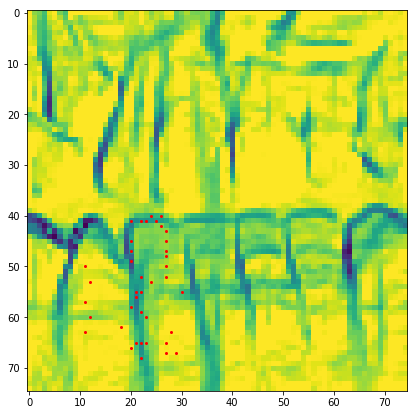

In [41]:
    new_ext = calc_external_img(new_img) 
    fm.show_with_points(new_ext, new_tooth)

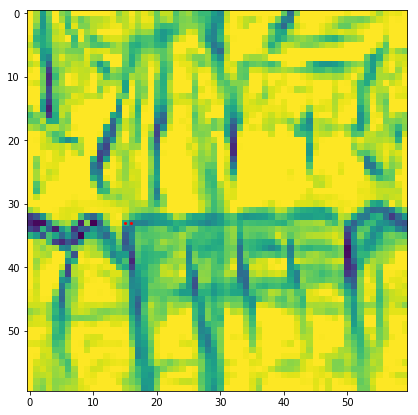

-0.36034358
0.7389755443226531
-2.864460210453348


In [44]:
    new_piece, new_tooth = resolution_scale(piece, tooth,1/10)

    mean = calc_mean(new_tooth)
    ext1 = calc_external_img(new_piece)
    fm.show_with_points(ext1, new_tooth[0:2])

    print(calc_external(new_tooth[0],ext1))
    print(calc_internal(new_tooth[0], new_tooth[1], mean))
    print(calc_energy(new_tooth[0],new_tooth[1],ext1,mean,10))



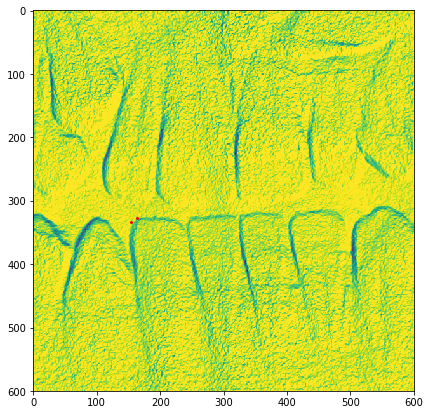

-0.117117114
0.9115847778002506
-0.259586365850758


In [45]:
    new_piece, new_tooth = piece, tooth 

    mean = calc_mean(new_tooth)
    ext = calc_external_img(new_piece)
    fm.show_with_points(ext, new_tooth[0:2])

    print(calc_external(new_tooth[0],ext))
    print(calc_internal(new_tooth[0], new_tooth[1], mean))
    print(calc_energy(new_tooth[0],new_tooth[1],ext,mean,10))


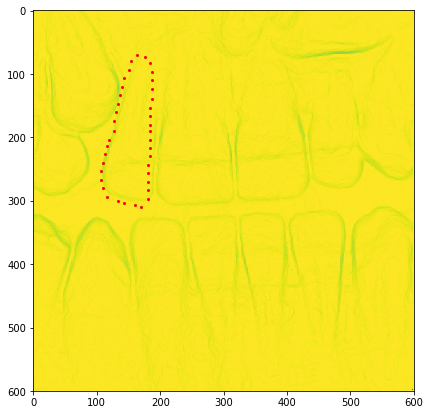

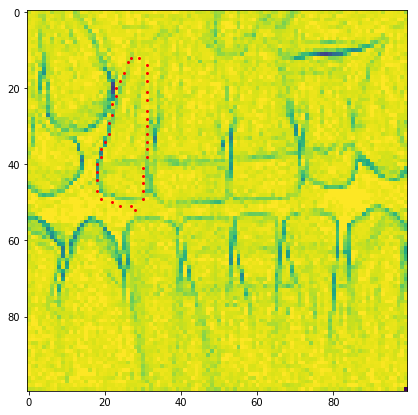

In [8]:
    piece = fm.load_img_piece()
    tooth = fm.load_tooth_of_piece(0)
    ext = calc_external_img2(piece) 
    fm.show_with_points(ext, tooth)
    ext2, stooth = fm.resolution_scale(ext, tooth, 1/6)
    ext = calc_external_img2(img) 
    fm.show_with_points(ext2, stooth)

In [11]:
    new_tooth = active_contour(stooth, ext2, 6, 1)
    fm.show_with_points(ext2, new_tooth)

C:\Users\Gebruiker\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Gebruiker\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 538976288 is out of bounds for axis 1 with size 13

In [60]:
piece = fm.load_img_piece()
edge_img = prep.canny(piece)
tooth = fm.load_tooth_of_piece(5)

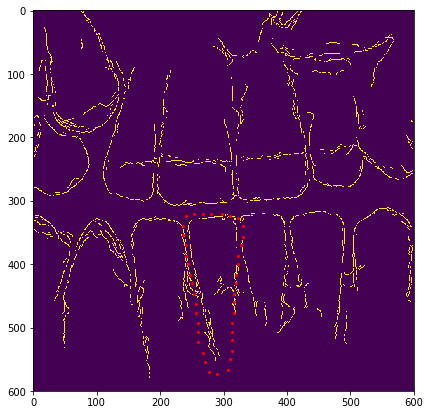

In [9]:
fm.show_with_points(edge_img, tooth)

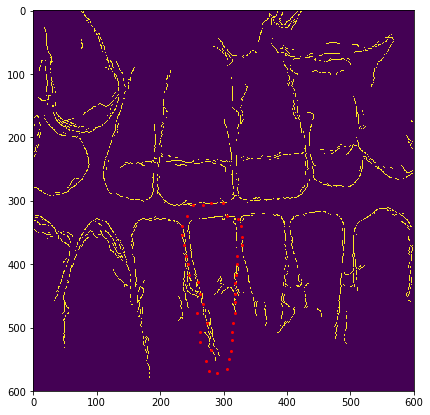

In [51]:
new_tooth = active_contour(tooth, edge_img, 25, 1)
fm.show_with_points(edge_img, new_tooth)

# for i in range(7):
#     tooth = fm.load_tooth_of_piece(i+1)
#     new_points, total_error = fit_measure(tooth, 25, edge_img)
#     new_points_list = np.append(new_points_list,new_points)
# fm.show_with_points(edge_img, new_points_list.reshape(-1,2))

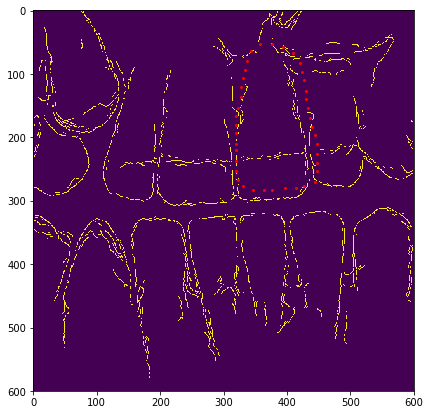

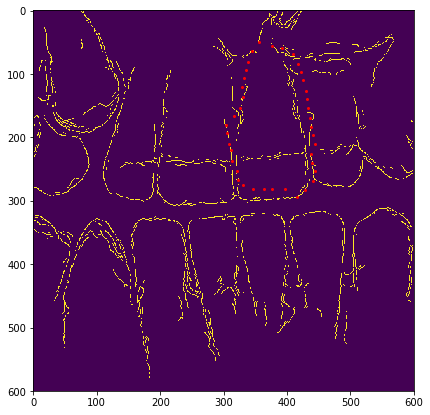

In [56]:
piece = fm.load_img_piece()
edge_img = prep.canny(piece)
tooth = fm.load_tooth_of_piece(2)
fm.show_with_points(edge_img, tooth)

new_tooth = active_contour(tooth, edge_img, 40, 1/2)
fm.show_with_points(edge_img, new_tooth)